### <center> Next-VolumeMap Prediction with Convolutional LSTMs </center> 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import h3
import json
import folium
from geojson.feature import *
import branca.colormap as cm 
from folium import Map, Marker, GeoJson 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

* https://keras.io/examples/vision/conv_lstm/ 

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
# libraries from Keras 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox 

In [6]:
# SELECT date, from_lat, from_lon, status, geozone_id from max_taxi_incoming_orders;

In [7]:
use_columns = ['date', 'from_lat', 'from_lon', 'status', 'geozone_id']

incoming_orders = pd.read_csv("mytaxi_test_max_taxi_incoming_orders.csv", usecols=use_columns)

incoming_orders = incoming_orders[incoming_orders.status == 7][:]
# incoming_orders = incoming_orders[incoming_orders.geozone_id == 3][:]   

incoming_orders.drop(columns=['status', 'geozone_id'], inplace=True)

In [8]:
hexagons_gridDF = pd.read_csv("hexagons_grid.csv") 

#### Date

In [9]:
incoming_orders['date'] = incoming_orders['date'].astype('datetime64[ns]')  

print("Min date: {}".format(incoming_orders['date'].min()))
print("Max date: {}".format(incoming_orders['date'].max()))

Min date: 2021-01-01 00:01:06
Max date: 2022-02-28 23:59:21


In [10]:
DATE_FROM = '2021-03-01 08:00:00' 
DATE_TO = '2021-03-01 08:30:00' 

incoming_orders_small = incoming_orders[(incoming_orders.date >= DATE_FROM) & (incoming_orders.date < DATE_TO)][:]
incoming_orders_small.shape

(342, 3)

In [11]:
resolution = 8 

df = incoming_orders_small[["from_lat", "from_lon"]] 

df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["from_lat"], row["from_lon"], resolution), axis = 1) 

df_aggreg = df.groupby(by = "hex_id").size().reset_index() 
df_aggreg.columns = ["hex_id", "value"] 

In [12]:
one_patch = pd.merge(hexagons_gridDF, df_aggreg, on='hex_id', how='left') 

one_patch.fillna(0, inplace=True) 

In [13]:
one_patch.sort_values(by='hex_id', inplace=True)

In [14]:
one_patch_numpy = one_patch['value'].values.reshape((28, 28))

one_patch_numpy

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  3.,  0.,  1.,  3.,  0.,  0.,  2.,  3.,  1.,
         1.,  2.],
       [ 4

Volume map


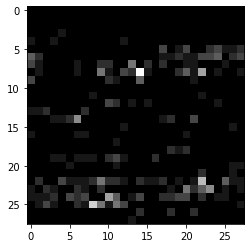

In [15]:
print("Volume map")

plt.figure(figsize = (4, 4))

plt.imshow(one_patch_numpy, cmap='gray', interpolation='nearest')
plt.show()

In [17]:
### adding two numpy volume maps 

simple_list = [one_patch_numpy] 
simple_list.append(one_patch_numpy) 
numpy_list = np.array(simple_list)

numpy_list.shape

(2, 28, 28)

#### Method 

In [18]:
print("Min date: {}".format(incoming_orders['date'].min()))
print("Max date: {}".format(incoming_orders['date'].max()))

Min date: 2021-01-01 00:01:06
Max date: 2022-02-28 23:59:21


In [19]:
def get_volume_map(df, hex_df): 
    ## only keeping long, lat 
    
    if df.shape[0] > 0: 
        df = df[["from_lat", "from_lon"]] 

        df["hex_id"] = df.apply(lambda row: h3.geo_to_h3(row["from_lat"], row["from_lon"], resolution), axis = 1) 

        df = df.groupby(by = "hex_id").size().reset_index() 
        df.columns = ["hex_id", "value"] 

        ### merging with hex_df 
        df = pd.merge(hex_df, df, on='hex_id', how='left')  
        df.fillna(0, inplace=True) 

        ### sort 
        df.sort_values(by='hex_id', inplace=True)  

        ### generating 28x28 numpy volume map  
        volume_map = df['value'].values.reshape((28, 28)) 
    else: 
        volume_map = np.zeros((28, 28))

    return volume_map 

In [20]:
print("Min date: {}".format(incoming_orders['date'].min()))
print("Max date: {}".format(incoming_orders['date'].max()))

Min date: 2021-01-01 00:01:06
Max date: 2022-02-28 23:59:21


In [ ]:
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta 

volume_maps = []
interval    = 10    ### in minutes 
start_date  = pd.Timestamp('202import tqdm1-01-01 00:00:00') 
end_date    = incoming_orders['date'].max()
stop_flag   = False 

total_minutes        = (incoming_orders['date'].max() - incoming_orders['date'].min()).total_seconds() // 60 
number_of_intervals  = int(total_minutes // interval)  

print("[!] Number of intervals: {}".format(number_of_intervals))

for i in tqdm(range(number_of_intervals)): 
    DATE_FROM = start_date + timedelta(minutes = interval * i)   
    DATE_TO   = DATE_FROM + timedelta(minutes = interval) 
    
    patch = incoming_orders[(incoming_orders.date >= DATE_FROM) & (incoming_orders.date < DATE_TO)][:] 
    
    volume_maps.append(get_volume_map(patch, hexagons_gridDF))
    
print("[!] Process is finished")

np_volume_maps = np.array(volume_maps)  

print("[!] Shape of volume map: {}".format(np_volume_maps.shape))

### save 
np.save("volume_maps_interval_{}".format(interval), np_volume_maps)

In [18]:
len(volume_maps) 

61055

In [11]:
interval = 10

volume_maps = np.load("volume_maps_interval_{}.npy".format(interval))

In [12]:
len(volume_maps) 

61055

#### Train and test 

In [13]:
train = volume_maps[:60000]   ## for train: 4000 frames 
test  = volume_maps[60000:]   ## for test: 415 frames 

### Sequences 

In [14]:
def make_sequence(data, sequence_length): 
    main_list = [] 
    
    for i in range(len(data) - sequence_length): 
        l = data[i:i+sequence_length]
        l = np.array(l)
        main_list.append(l)
    
    return np.array(main_list)

In [81]:
sequence_length = 10 

train_dataset = make_sequence(train, sequence_length)
test_dataset  = make_sequence(test, sequence_length)

# Add a channel dimension since the images are grayscale.
train_dataset = np.expand_dims(train_dataset, axis=-1)
test_dataset  = np.expand_dims(test_dataset, axis=-1)

print("[!] Shape of train sequence: {}".format(train_dataset.shape))
print("[!] Shape of test sequence:  {}".format(test_dataset.shape))

[!] Shape of train sequence: (59990, 10, 28, 28, 1)
[!] Shape of test sequence:  (1045, 10, 28, 28, 1)


#### Data Visualization

Displaying volume maps for example 26453.


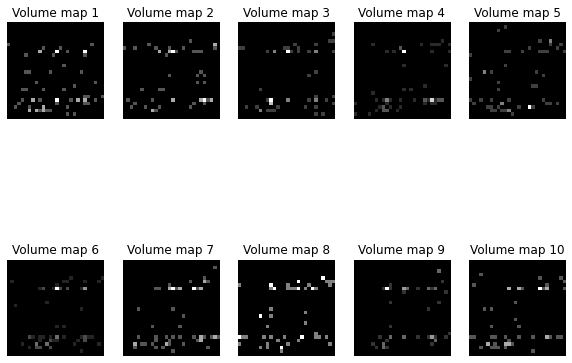

In [84]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Volume map {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying volume maps for example {data_choice}.")
plt.show() 

In [85]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [86]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
test_dataset = test_dataset / 255

In [87]:
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(test_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (59990, 9, 28, 28, 1), (59990, 9, 28, 28, 1)
Validation Dataset Shapes: (1045, 9, 28, 28, 1), (1045, 9, 28, 28, 1)


#### Model Construction

In [88]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

#### Model Training 

In [89]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 7

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8570/8570 [==============================] - ETA: 0s - loss: 0.0019WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fce6663aea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8570/8570 [==============================] - 4083s 476ms/step - loss: 0.0019 - val_loss: 0.0019 - lr: 0.0010
Epoch 2/5
8570/8570 [==============================] - 4089s 477ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 3/5
8570/8570 [==============================] - 4093s 478ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 4/5
8570/8570 [==============================] - 4090s 477ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010
Epoch 5/5
8570/8570 [==============================] - 4095s 478ms/step - loss: 0.0015 - val_loss: 0.0019 - lr: 0.0010


In [90]:
model.save('model_demand_pred_5epoch_10mins_10frames')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: model_demand_pred_5epoch_10mins_10frames/assets


INFO:tensorflow:Assets written to: model_demand_pred_5epoch_10mins_10frames/assets


In [91]:
from tensorflow import keras
loaded_model = keras.models.load_model('model_demand_pred_5epoch_10mins_10frames')

In [92]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 28, 28, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 28, 28, 64)  416256    
                                                                 
 batch_normalization_2 (Batc  (None, None, 28, 28, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 28, 28, 64)  295168    
                                                                 
 batch_normalization_3 (Batc  (None, None, 28, 28, 64)  256      
 hNormalization)                                                 
                                                           

#### Volume-Map Prediction Visualizations 

In [93]:
### Displaying volume maps for example 2972.

Displaying volume maps for example 26453.


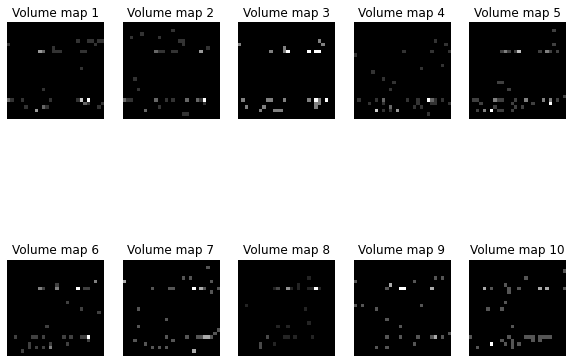

In [281]:
# Select a random example from the validation dataset.
example = test_dataset[np.random.choice(range(len(test_dataset)), size=1)[0]]

# example = test_dataset[2972]

# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(example[idx]), cmap="gray")
    ax.set_title(f"Volume map {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying volume maps for example {data_choice}.")
plt.show() 

In [282]:
example.shape

(10, 28, 28, 1)

In [283]:
# Pick the first/last ten frames from the example.
frames = example[:9, ...]
original_frames = example[1:, ...]

# Predict a new set
new_prediction = loaded_model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

1/1 [==============================] - 0s 81ms/step


In [284]:
frames.shape

(9, 28, 28, 1)

In [285]:
new_prediction.shape

(9, 28, 28, 1)

Predicted map


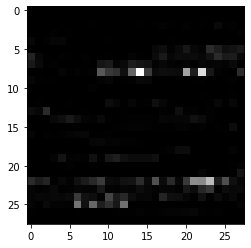

In [286]:
print("Predicted map")

plt.figure(figsize = (4, 4))

plt.imshow(np.squeeze(new_prediction[-1, ...])*255, cmap='gray', interpolation='nearest')
plt.show()

Original map


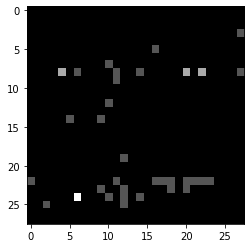

In [287]:
print("Original map")

plt.figure(figsize = (4, 4))

plt.imshow(np.squeeze(example[-1, ...])*255, cmap='gray', interpolation='nearest')
plt.show()

### Visualization on real map 

In [288]:
true_map = np.squeeze(example[-1, ...])*255
true_map = np.squeeze(true_map.reshape((28*28, 1))) 

true_map_df = hexagons_gridDF.copy()
true_map_df['value'] = true_map 

true_map_df["geometry"] = true_map_df.hex_id.apply(lambda x: {"type" : "Polygon",
                                                           "coordinates": [h3.h3_to_geo_boundary(h=x,geo_json=True)]})

In [289]:
prediction = np.around(np.squeeze(new_prediction[-1, ...])*255)
prediction = np.squeeze(prediction.reshape((28*28, 1))) 

prediction_df = hexagons_gridDF.copy()
prediction_df['value'] = prediction

prediction_df["geometry"] = prediction_df.hex_id.apply(lambda x: {"type" : "Polygon",
                                                           "coordinates": [h3.h3_to_geo_boundary(h=x,geo_json=True)]})

In [290]:
true_num = np.sum( np.squeeze(example[-1, ...])*255)
pred_num = np.sum(np.around(np.squeeze(new_prediction[-1, ...])*255))

print("True demand {}".format(true_num))
print("Pred demand {}".format(pred_num))

True demand 39.0
Pred demand 14.0


### Show 

In [291]:
from map_functions import * 

# Creates a map using Folium
true_hexmap = choropleth_map(df_aggreg = true_map_df, with_legend = True, kind = "linear", max_val=5) 
pred_hexmap = choropleth_map(df_aggreg = prediction_df, with_legend = True, kind = "linear", max_val=5) 

In [292]:
true_hexmap

In [293]:
pred_hexmap